In [1]:
import numpy as np
import scipy.optimize as spo
import pylab as pl
%pylab inline
%load_ext autoreload
%autoreload 2
# These 2 lines get rid of the stupid debug error from Fenics 
# import logging
# logging.getLogger("FFC").setLevel(logging.ERROR) 

Populating the interactive namespace from numpy and matplotlib


Functions for the monomials

In [2]:
def getc(x,y,ncurves,cl,N):
    curr = np.zeros((ncurves,N,N,2))
    # Make the curves periodic
    x = np.concatenate((x,(x[:,0]*np.ones((1,np.shape(x)[0]))).T),axis=1)
    y = np.concatenate((y,(y[:,0]*np.ones((1,np.shape(y)[0]))).T),axis=1)
    for i in range(ncurves):
        for m in range(N):
            for n in range(N):
                curr[i,m,n,:] = current(x[i,:],y[i,:],m,n)

    curr2 = np.reshape(curr,[ncurves,N*N*2],order='F').copy()
    return x,y,curr,curr2

def current(x,y,m,n):
    npoints = np.shape(x)[0]-1
    w = ((x[:npoints]+x[1:])/2.0)**m * ((y[:npoints]+y[1:])/2.0)**n
    c = np.array([np.sum(w*np.diff(x)),np.sum(w*np.diff(y))])
    index = np.where(np.abs(c)<1e-14)
    if np.shape(index)[1]>0:
        c[index] = 0
    return c


In [3]:
def dualnorm(N):
    G = np.zeros((N,N,N,N))
    for m1 in range(N):
        for m2 in range(N):
            for n1 in range(N):
                for n2 in range(N):
                    G[m1,m2,n1,n2] = 10.0*(1.0/(m1+n1+1.0) - (-1.0)**(m1+n1+1.0)/(m1+n1+1.0)) * (1.0/(m2+n2+1.0) - (-1.0)**(m2+n2+1.0)/(m2+n2+1.0))
                    if (m1*n1 > 0):
                        G[m1,m2,n1,n2] = G[m1,m2,n1,n2] + (1.0+(-1.0)**(m1+n1)) * (1.0+(-1.0)**(m2+n2)) * m1*n1/(m1+n1-1.0)/(m2+n2+1.0)
                    if (m2*n2 > 0):
                        G[m1,m2,n1,n2] = G[m1,m2,n1,n2] + (1.0+(-1.0)**(m1+n1)) * (1.0+(-1.0)**(m2+n2)) * m2*n2/(m1+n1+1.0)/(m2+n2-1.0)

    G = np.reshape(G,(N*N,N*N),order='F').copy()
    #Gi = np.linalg.inv(G)
    #from scipy.linalg import block_diag
    #Gi = block_diag(Gi,Gi)
    #G = block_diag(G,G)
    return G

In [4]:
# Generate random Fourier shapes
def randshapes(ncurves,npoints):
    x = np.zeros((ncurves,npoints))
    y = np.zeros((ncurves,npoints))
    t = np.arange(0,2*np.pi,2*np.pi/npoints)
    t = t*np.ones((1,np.shape(t)[0]))
    nfourier = 6
    fr = np.concatenate((np.arange(nfourier+1),np.arange(-nfourier,0)),axis=0)
    fr = fr*np.ones((1,np.shape(fr)[0]))

    for shape in range(ncurves):
        a = (np.random.randn(2*nfourier+1) + 1j*np.random.randn(2*nfourier+1))
        a = a*np.ones((1,np.shape(a)[0]))
        a = a/(1+np.abs(fr)**3)

        a[0,0] = 0
        a[0,1] /= np.abs(a[0,1])
        a[0,-1] = 0;

        z = np.dot(a,np.exp(1j*np.tile(fr.T,(1,npoints))*np.tile(t,(2*nfourier+1,1))))
        x[shape,:] = 0.5*np.real(z)
        y[shape,:] = 0.5*np.imag(z)
    return x, y

In [5]:
# This is the representer for the monomials
def representer(x,y,ncurves,cl,npoints,N):
    [x,y,curr,curr2] = getc(x,y,ncurves,cl,N)
    [Gi,G] = dualnorm(N)
    
    u = np.zeros((ncurves,N,N,2))
    for i in range(ncurves):
        u1 = np.linalg.solve(G,curr2[i,:].T)
        u1 = np.reshape(u1,[N,N,2],order='F').copy()
        u[i,:,:,:] = u1
        
    #meshing = 2/0.05
    #Fix size of U if wish to use!
    #X,Y = np.meshgrid(np.linspace(-1,1,meshing),np.linspace(-1,1,meshing))
    #U = np.zeros((ncurves,np.shape(X)))
    #V = np.zeros((ncurves,np.shape(Y)))
    #print np.shape(U)

    #for i in range(ncurves):
    #    for m in range(N-1):
    #        for n in range(N-1):
    #            U[i] += X**m*Y**n*u[i,m+1,n+1,0]
    #            V[i] += X**m*Y**n*u[i,m+1,n+1,1]

    #print X, Y, U, V
    #print (np.max(np.sqrt(U**2+V**2), np.sqrt(np.dot(u1.T,np.dot(G,u1)))))

    return u
    #pl.figure()
    #pl.plot(x,y,'r')
    #pl.quiver(X,Y,U.astype("float64"),V.astype("float64"),'b')
    #pl.axis('equal')


In [6]:
# Should take representer in either form and compute PCA
# Need to fix the plotting a little
def compute_pca(pe):
    D,Evec = np.linalg.eig(np.cov(pe.T))
    order = np.argsort(D)
    Evec = np.real(Evec)

    pr = np.dot(pe,Evec[:,order[-2:]])
    #pl.plot(pr[:,0],pr[:,1],'.')
    pl.figure()
    for i in range(np.shape(pr)[0]):
        pl.plot(pr[i,1],pr[i,0],'.')
        pl.text(pr[i,1],pr[i,0],i)
    pl.axis('equal')

    pl.figure()
    for i in range(np.shape(pr)[0]):
        pl.plot(pr[i,1] + 0.5*x[i,:],pr[i,0] + 0.5*y[i,:]/5,'.')
        pl.text(pr[i,1] + x[i,0],pr[i,0] + y[i,0],i)
    pl.axis('equal')

In [7]:
# Get the representers from the FE code
import femshape2 as fem
#reload(fem)
shapecalc = fem.FEMShapeInvariant(order=4, meshsize=3,L=1)

def rep_fem(x,y):
    Uret = []
    Vret = []
    H1ret = []
    H2ret = []
    Mret = []
    dxret = []
    dyret = []
    for count in range(np.shape(x)[0]):
        inv1 = shapecalc.compute_invariants(np.vstack((x[count,:],y[count,:])).T,closed=True)
        U, V, H1, H2, M, invx, invy = shapecalc.calcM(ret_inv=True,invariants=inv1)
        Uret.append(U)
        Vret.append(V)
        H1ret.append(H1)
        H2ret.append(H2)
        Mret.append(M)
        dxret.append(invx)
        dyret.append(invy)
        #U[:,count], V[:,count], H1[count], H2[count] = shapecalc.calcM()
    return np.squeeze(np.array(Uret)), np.squeeze(np.array(Vret)), np.array(H1ret), np.array(H2ret), np.array(Mret), np.array(dxret), np.array(dyret)

ValueError: too many values to unpack (expected 2)

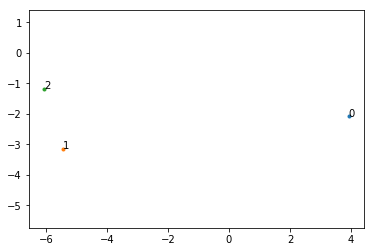

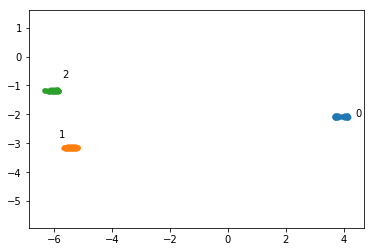

In [10]:
#Test 1: Construct 5 random variations of the circle and a figure of 8
npoints = 50
ncurves = 3
x = np.zeros((ncurves,npoints))
y = np.zeros((ncurves,npoints))

x[1:,:],y[1:,:] = randshapes(ncurves-1,npoints)

x[0,:] = 0.5*np.cos(np.linspace(0,2*np.pi,npoints,endpoint=False))
y[0,:] = 0.5*np.sin(2*np.linspace(0,2*np.pi,npoints,endpoint=False))

# Using the finite elements
U,V,H1,H2, M, dx, dy = rep_fem(x,y)
pe = np.transpose(np.array((U,V)),(1,0,2))
#pl.plot(U[2,:],V[2,:],'.')
ninv = np.shape(pe)[2]
pe = np.reshape(pe,(ncurves,ninv*2),order='F')
compute_pca(pe)

# Using the monomials
cl = (npoints-1)*np.ones((1,ncurves),dtype=int)
u = representer(x,y,ncurves,cl,npoints,10)
u1 = np.zeros((ncurves,np.shape(u)[1]*np.shape(u)[2]*2))
for i in range(ncurves):
    u1[i,:] = np.matrix.flatten(u[i,:,:,:])
compute_pca(u1)

In [15]:
M.shape

(3, 169, 169)

In [ ]:


# PCA on the representer space, not Euclidean space
ncurves = 32
data = spi.loadmat('currents_data_200_500.mat')
x = data['x']
y = data['y']
x = x[:ncurves,:]
y = y[:ncurves,:]
U,V,H1,H2,M,dx,dy = rep_fem(x,y)
pe = np.transpose(np.array((U,V)),(1,0,2))
#pl.plot(U[2,:],V[2,:],'.')
ninv = np.shape(pe)[2]
pe = np.reshape(pe,(ncurves,ninv*2),order='F')
compute_pca(pe)

cl = (npoints-1)*np.ones((1,ncurves),dtype=int)
u = representer(x,y,ncurves,cl,npoints,10)
u1 = np.zeros((ncurves,np.shape(u)[1]*np.shape(u)[2]*2))
for i in range(ncurves):
    u1[i,:] = np.matrix.flatten(u[i,:,:,:])
compute_pca(u1)

In [244]:
# PCA
def pca_opt(pe,x,y,name='',scaling=20):
    ncurves = np.shape(pe)[0]
    # Centre the pe matrix
    a = pe.mean(axis=0)
    a = (a*np.ones((1,np.shape(pe)[1]))).T
    a = np.tile(a,(1,np.shape(pe)[0]))
    pe = pe - a.T

    # Compute the PCA
    D,V = np.linalg.eig(np.cov(pe.T))
    order = np.argsort(D)
    V = np.real(V)

    pr = np.dot(pe,V[:,order[-2:]])
    
    for i in range(ncurves):
        pl.plot(-pr[i,0]+ x[i,:]/scaling,pr[i,1] + y[i,:]/scaling)
        pl.plot(-pr[i,0],pr[i,1],'.')
        pl.text(-pr[i,0],pr[i,1],i)
    pl.xlabel('PC1')
    pl.ylabel('PC2')
    pl.axis('tight')
    if name!='':
        pl.savefig(name+'.pdf',dpi=600)
    #a = pl.gca()
    #a.axes.xaxis.set_ticklabels([])
    #a.axes.yaxis.set_ticklabels([])
        
    d = np.zeros((ncurves,ncurves))    
    for i in range(ncurves-1):
        for j in range(i,ncurves):
            d[i,j] = np.linalg.norm(pe[i,:] - pe[j,:])
    d = d + d.T

    # Optimisation
    pr2 = np.reshape(pr, [np.shape(pr)[0]*np.shape(pr)[1]])
    # N = #params in pr2, M = # datapoints
    pr3,dummy = spo.leastsq(objfun,pr2,args=d)
    o = objfun(pr3,d)
    o = np.reshape(o,[ncurves-1,ncurves])
    p = objfun(pr2,d)
    p = np.reshape(p,[ncurves-1,ncurves])
    print (np.sqrt(np.linalg.norm(p)**2/(ncurves*(ncurves-1)/2.)))
    print (np.sqrt(np.linalg.norm(o,'fro')**2/(ncurves*(ncurves-1)/2.)))
    pr3 = np.reshape(pr3, np.shape(pr))

    # Centre the pr3 matrix -- optimiser makes is wander
    a = pr3.mean(axis=0)
    a = (a*np.ones((1,np.shape(pr3)[1]))).T
    a = np.tile(a,(1,np.shape(pr3)[0]))
    pr3 = pr3 - a.T
    pr3 = 2*pr3
    
    pl.figure()
    for i in range(ncurves):
        pl.plot(-pr3[i,0]+x[i,:]/(scaling/2.5),pr3[i,1]+y[i,:]/(scaling/2.5))
        pl.plot(-pr3[i,0],pr3[i,1],'.')
        pl.text(-pr3[i,0],pr3[i,1],i)
    pl.axis('equal')
    pl.xlabel('PC1')
    pl.ylabel('PC2')
    pl.axis('tight')
    if name!='':
        pl.savefig(name+'_opt.pdf',dpi=600)
    
    #a = pl.gca()
    #a.axes.xaxis.set_ticklabels([])
    #a.axes.yaxis.set_ticklabels([])
    
# Objective function for optimisation of the curve placement
def objfun(pl,d):
    # Compute how well the 2D positions match between pl and d
    pl = np.reshape(pl,[np.shape(pl)[0]/2.,2])
    ncurves = np.shape(d)[0]
    e = np.zeros((ncurves-1,ncurves))
    for i in range(ncurves-1):
        for j in range(i+1,ncurves):
            e[i,j] = np.sqrt((pl[i,0]-pl[j,0])**2 + (pl[i,1]-pl[j,1])**2) - d[i,j]
    return np.reshape(e,[(ncurves-1)*ncurves])

In [239]:
# This version is like Robert's, does PCA on the currents of the curve (not the representer)
def current_pca(ncurves=32,npoints=500,N=10):
    pl.ion()
    cl = (npoints-1)*np.ones((1,ncurves),dtype=int)
    #x,y = randshapes(ncurves,npoints)
    data = spi.loadmat('currents_data_200_500.mat')
    x = data['x']
    y = data['y']
    x = x[:ncurves,:]
    y = y[:ncurves,:]
    #x[0,:] = 0.5*np.cos(np.linspace(0,2*np.pi,npoints,endpoint=False))
    #y[0,:] = 0.5*np.sin(2*np.linspace(0,2*np.pi,npoints,endpoint=False))
    x,y,curr,curr2 = getc(x,y,ncurves,cl,N)

    G = dualnorm(N)
    L = np.linalg.cholesky(G)
    Linv = np.linalg.inv(L)
    from scipy.linalg import block_diag
    Gihalf = block_diag(Linv,Linv)
    
    #Ghalf = np.linalg.cholesky(G).T

    # representer in Euclidean basis
    #ue = np.dot(Ghalf,u1)
    #print (np.sqrt(np.dot(u1.T,np.dot(G,u1))),np.linalg.norm(ue))
    #Gihalf = np.linalg.cholesky(Gi).T

    pe = np.zeros(np.shape(curr2))
    for i in range(ncurves):
        pe[i,:] = np.dot(Gihalf,curr2[i,:].T).T

    pca_opt(pe,x,y,'monomial',20)

0.101778668419
0.0660085137363


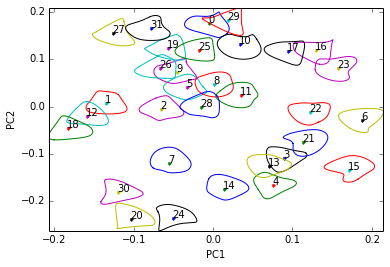

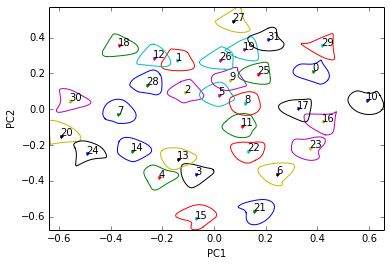

In [240]:
current_pca()

In [276]:
# Save a load of data into matlab file for easy comparison
import scipy.io as spi
ncurves = 200
npoints = 500
x,y = randshapes(ncurves,npoints)
spi.savemat('currents_data_200_500.mat',{'x':x,'y':y})

In [230]:
# This version is like Robert's, does PCA on the currents of the curve (not the representer)
import scipy.io as spi
def fem_current_pca(ncurves=32,npoints=500,order=1,meshsize=10):
    pl.ion() 
    #x,y = randshapes(ncurves,npoints)
    data = spi.loadmat('currents_data_200_500.mat')
    x = data['x']
    y = data['y']
    x = x[:ncurves,:]
    y = y[:ncurves,:]
    #x[0,:] = 0.5*np.cos(np.linspace(0,2*np.pi,npoints,endpoint=False))
    #y[0,:] = 0.5*np.sin(2*np.linspace(0,2*np.pi,npoints,endpoint=False))
    
    U,V,H1,H2, G, invx, invy = rep_fem(x,y)
    G = np.squeeze(G[0,:,:])
    
    # For the H^1 metric use L = np.linalg.cholesky(G)
    L = np.linalg.cholesky(G)
    # For the H^2 metric use L = G
    #L=G
    
    Linv = np.linalg.inv(L)
    from scipy.linalg import block_diag
    Gihalf = block_diag(Linv,Linv)
    
    curr2 = np.hstack((invx,invy))

    # representer in Euclidean basis
    pe = np.zeros(np.shape(curr2))
    for i in range(ncurves):
        pe[i,:] = np.dot(Gihalf,curr2[i,:].T).T

    name = 'fem_'+str(order)+'_'+str(meshsize)
    pca_opt(pe,x,y,name,8)

0.378729576766
0.242306302057


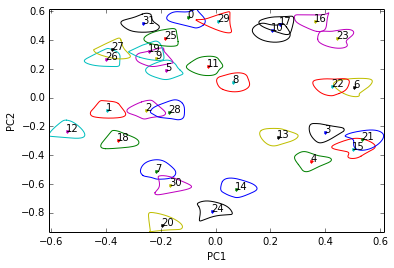

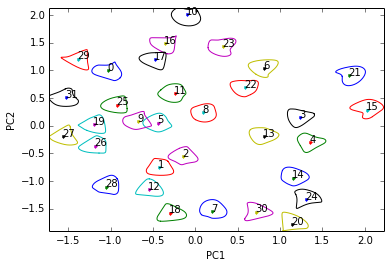

In [245]:
import femshape2 as fem
reload(fem)
shapecalc = fem.FEMShapeInvariant(order=1, meshsize=10,L=1)
fem_current_pca(order=1,meshsize=10)
#shapecalc = fem.FEMShapeInvariant(order=1, meshsize=20,L=1)
#pe2, d = fem_current_pca()
#shapecalc = fem.FEMShapeInvariant(order=4, meshsize=20,L=1)
#pe = fem_current_pca()

In [255]:
d(0,1), d(0,2), d(0,3)
order 1, mesh = 10, 20, 40
(2.2949783713748606, 2.4006275209345507, 2.2316118057013319)
(1.6047046605854045, 1.6207933275335604, 1.6825498540372308)
(1.2664142928892494, 1.2783837142622918, 1.3259963291001282)

order 4, mesh = 5, 10, 20
(2.2997301392640863, 2.2460204102017722, 2.2746276352501957)
(1.7498901419675774, 1.7855146077354773, 1.7592703776709591)

d(0,1), d(0,2), d(1,2)
order 4, mesh = 5, 10, 20
(2.7899967862469111, 2.8270892665201925, 0.8246409669811765)
(2.8852668644254802, 2.9246305575121454, 1.0339455136119406)
(2.9389698376057898, 2.9713066427066308, 1.1315582359980916)

(0.00011386594190346711, 0.00021340940971341336, -5.9123874213563773e-05)


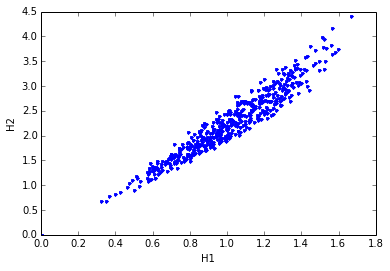

In [248]:
pl.plot(dH1,dH2,'b.')
pl.xlabel('H1')
pl.ylabel('H2')
pl.savefig('scatterH1H2.pdf',dpi=600)

In [171]:
help(pl.savefig)

Help on function savefig in module matplotlib.pyplot:

savefig(*args, **kwargs)
    Save the current figure.
    
    Call signature::
    
      savefig(fname, dpi=None, facecolor='w', edgecolor='w',
              orientation='portrait', papertype=None, format=None,
              transparent=False, bbox_inches=None, pad_inches=0.1,
              frameon=None)
    
    The output formats available depend on the backend being used.
    
    Arguments:
    
      *fname*:
        A string containing a path to a filename, or a Python
        file-like object, or possibly some backend-dependent object
        such as :class:`~matplotlib.backends.backend_pdf.PdfPages`.
    
        If *format* is *None* and *fname* is a string, the output
        format is deduced from the extension of the filename. If
        the filename has no extension, the value of the rc parameter
        ``savefig.format`` is used.
    
        If *fname* is not a string, remember to specify *format* to
        ensur